# Transit Boardings Validation Report

### NOTE: OBSERVED = 2016 NETWORK, MODEL = 2019 GTFS NETWORK

In [45]:
from validation_reports import notebook
from validation_reports import trn_summ
import pandas as pd
import geopandas as gpd
import numpy as np

### Set path to model outputs

In [46]:
nb = notebook()
trn = trn_summ(scen=r"J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\Base")
gtrn = trn_summ(scen=r"J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\GTFS_20221216")

directory ./outputs exists


In [47]:
gtrn.scen = r"J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\GTFS_20221216"
trn.scen = r"J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\Base"
gtrn.scen

'J:\\Shared drives\\TMD_TSA\\Model\\networks\\Transit\\gtfs\\tdm23\\outputs\\GTFS_20221216'

In [48]:
gtrn.load_model()
trn.load_model()
trn.mod_df.columns

c:\Users\matkinson.AD\Documents\tdm23_vr\validation_reports\transit_loader.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_df['on'] = 0


Model outputs from J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\GTFS_20221216 loaded as mod_df
Model outputs from J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\Base loaded as mod_df


Index(['mode', 'operator', 'line', 'stop', 'tod', 'boardings'], dtype='object')

In [49]:
trn.mod_df['line'] = trn.mod_df['line'].str.lstrip("0")

In [50]:
gtrn.mod_df['mode'] = np.where(gtrn.mod_df['line'].isin(["171", "426", "441", "442", "450","455"]), "xbus", gtrn.mod_df['mode'])

In [51]:
trn.mod_df.shape

(38990, 6)

In [52]:
gtrn.mod_df.shape

(65150, 6)

In [53]:
# build some handy dataframes
#daily counts (separate from tod to avoid double counting)
daily_mod = trn.mod_df[trn.mod_df['tod']=='daily']
gdaily_mod = gtrn.mod_df[gtrn.mod_df['tod']=='daily']

# time of day (drop daily and modes that do not have tod)
tod_mod = trn.mod_df[(trn.mod_df['tod']!='daily')&(trn.mod_df['mode'].isin(['lbus','hr','brt','lrt']))]
gtod_mod = gtrn.mod_df[(gtrn.mod_df['tod']!='daily')&(gtrn.mod_df['mode'].isin(['lbus','hr','brt','lrt']))]

Calculate Frequency per Primary Route to see if changes to this cause any problems down the line for ridership.

In [54]:
gtrn_routes = gpd.read_file(gtrn.scen + r"\_networks\routes.shp")
trn_routes = gpd.read_file(trn.scen + r"\_networks\routes.shp")

In [55]:
trn_routes[trn_routes['PRIMARY_RO'].isin(["710","712","713","714","716"])]['OPERATOR'] = 'MBTA'
trn_routes[trn_routes['PRIMARY_RO'].isna()].query('MODE < 3')
# 712 is a privately operated bus route according to wikipedia.

c:\Users\matkinson.AD\.conda\envs\tdm23_viz_plotly\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,ROUTE_ID,ROUTE_NAME,DIR,MODE,OPERATOR,PRIMARY_RO,TRIP_HEAD_,OLD_MODE,DESC,FARE_TYPE,...,FARE_CORE,FUEL_TYPE,AVAILABLE,HEADWAY_AM,HEADWAY_MD,HEADWAY_PM,HEADWAY_NT,PROJECT_NA,PROJECT_ID,geometry
431,5079,352: Burlington to Boston via I-,IB or SB,2,None,None,None,3,None,None,...,NaN,None,1,54.88,360.0,36.590000,360.0,None,None,"LINESTRING (223682.137 918832.217, 223702.661 ..."
681,6063,712:PT SHIRLEY - ORIENT IB,IB,1,None,None,None,1,None,None,...,NaN,None,1,0.00,0.0,0.000000,0.0,None,None,"LINESTRING (243696.162 900855.205, 243680.416 ..."
1412,8781,120: Orient Heights,OB or NB,1,None,None,None,1,None,None,...,NaN,None,1,22.50,22.5,25.714286,40.0,None,None,"LINESTRING (237927.798 902204.963, 237953.429 ..."


In [56]:
gtrn_routes[gtrn_routes['PRIMARY_RO'].isna()].query('MODE < 3')

,ROUTE_ID,ROUTE_NAME,DIR,MODE,OPERATOR,PRIMARY_RO,TRIP_HEAD_,OLD_MODE,DESC,FARE_TYPE,...,FARE_CORE,FUEL_TYPE,AVAILABLE,HEADWAY_AM,HEADWAY_MD,HEADWAY_PM,HEADWAY_NT,PROJECT_NA,PROJECT_ID,geometry


In [57]:
gtrn_routes['am_freq']  = 180/gtrn_routes['HEADWAY_AM']
gtrn_routes['md_freq']  = 330/gtrn_routes['HEADWAY_MD']
gtrn_routes['pm_freq']  = 240/gtrn_routes['HEADWAY_PM']
gtrn_routes['nt_freq']  = 690/gtrn_routes['HEADWAY_NT']
gtroutes = gtrn_routes[['PRIMARY_RO','am_freq','md_freq','pm_freq','nt_freq']].groupby(by='PRIMARY_RO').sum()
gtroutes = gtroutes.reset_index()
gtroutes['PRIMARY_RO'] = gtroutes['PRIMARY_RO'].str.lstrip("0")

trn_routes['am_freq']  = 180/trn_routes['HEADWAY_AM']
trn_routes['md_freq']  = 330/trn_routes['HEADWAY_MD']
trn_routes['pm_freq']  = 240/trn_routes['HEADWAY_PM']
trn_routes['nt_freq']  = 690/trn_routes['HEADWAY_NT']
troutes = trn_routes[['PRIMARY_RO','am_freq','md_freq','pm_freq','nt_freq']].groupby(by='PRIMARY_RO').sum()
troutes = troutes.reset_index()
troutes['PRIMARY_RO'] = troutes['PRIMARY_RO'].str.lstrip("0")

In [58]:
routes_freq = gtroutes.merge(troutes, on="PRIMARY_RO", suffixes = ['_gtfs','_2016'], how='outer')
# note that 191-194 are one offs for fare collectors and 717 doesn't exist
routes_freq.query('am_freq_gtfs != am_freq_2016')

,PRIMARY_RO,am_freq_gtfs,md_freq_gtfs,pm_freq_gtfs,nt_freq_gtfs,am_freq_2016,md_freq_2016,pm_freq_2016,nt_freq_2016
0,1,39.0,48.000000,57.999999,129.785715,86.000004,152.166670,140.000018,391.000027
1,10,19.0,21.666667,19.000000,47.642857,NaN,NaN,NaN,NaN
2,100,15.0,19.000000,21.000000,31.214286,NaN,NaN,NaN,86.250000
3,101,38.0,27.000000,34.000000,41.071429,inf,NaN,NaN,NaN
4,104,24.0,19.000000,27.000000,49.285714,NaN,28.416667,42.666667,65.166667
...,...,...,...,...,...,...,...,...,...
199,191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.583333
200,192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.833333
201,193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.666667
202,194,NaN,NaN,NaN,NaN,inf,inf,inf,5.750000


In [59]:
daily_mod.groupby('mode').sum().reset_index().sort_values(by='mode')

,mode,boardings
0,lbus,795239.655265
1,xbus,60572.709779
2,brt,22865.825656
3,lrt,203974.063840
4,hr,673660.190484
5,cr,158770.737147
6,bt,6362.680406
7,shtl,13740.480667
8,rta,181879.156621
9,regb,32394.289480


## Summaries

#### Daily transit boardings by mode (note not all modes have observations)

In [60]:
mb = daily_mod.groupby('mode').sum().reset_index().sort_values(by='boardings').merge(
    gdaily_mod.groupby('mode').sum().reset_index().sort_values(by='boardings'), on='mode', suffixes=['_2016','_gtfs'])
mb['deltad'] = mb['boardings_gtfs'] - mb['boardings_2016']
mb['deltap'] = mb['deltad']/mb['boardings_2016']*100
mb

,mode,boardings_2016,boardings_gtfs,deltad,deltap
0,bt,6362.680406,6693.185461,330.505055,5.194431
1,shtl,13740.480667,13164.989810,-575.490857,-4.188288
2,brt,22865.825656,28683.114228,5817.288572,25.440973
3,regb,32394.289480,37504.040072,5109.750592,15.773615
4,xbus,60572.709779,64980.068119,4407.358341,7.276145
5,cr,158770.737147,167299.552456,8528.815309,5.371780
6,rta,181879.156621,183146.597319,1267.440698,0.696859
7,lrt,203974.063840,229334.151693,25360.087853,12.432996
8,hr,673660.190484,713302.411194,39642.220710,5.884602
9,lbus,795239.655265,736056.652138,-59183.003127,-7.442159


#### Line Level Detail Summaries BY MODE

Start looking at lines within modes with big daily issues - express buses, BRT, local buses (some are very high).

Silver Line 4 & 5 (749, 751) high


##### BRT

In [ ]:
# Why are Local Bus so high - is there a particular line?
nb.compare_oneway(obsrvdf = daily_mod.query("mode == 'brt'"),
                  modeldf = gdaily_mod.query("mode == 'brt'"),
                  aggcol = 'boardings',col = 'line', aggmtd='sum')

##### Express Bus

In [ ]:
nb.compare_oneway(obsrvdf = daily_mod.query("mode == 'xbus'"),
                  modeldf = gdaily_mod.query("mode == 'xbus'"),
                  aggcol = 'boardings',col = 'line', aggmtd='sum')

##### Local Bus

In [ ]:
# Why are Local Bus so high - is there a particular line?
nb.compare_oneway(obsrvdf = daily_mod.query("mode == 'lbus'"),
                  modeldf = gdaily_mod.query("mode == 'lbus'"),
                  aggcol = 'boardings',col = 'line', aggmtd='sum')

### Line Level Summaries - All Routes - Identify Routes with High Delta %s

Export the csv "oneway_line_boarding.csv"

no weighted columns identified list index out of range:


(                       model    observed     deltaD  deltaP
 line                                                       
                   233626.548  226687.828   6938.720    3.06
 1                  31360.939   57936.502 -26575.563  -45.87
 10                  1600.157    3693.253  -2093.096  -56.67
 100                 1948.333    6911.258  -4962.925  -71.81
 101                10385.871    9114.647   1271.224   13.95
 ...                      ...         ...        ...     ...
 Orange Line       277186.045  274237.255   2948.790    1.08
 Plymouth Line       3717.065    4282.894   -565.829  -13.21
 Provdn/Stou Line   25712.765   25568.925    143.840    0.56
 Red Line          331897.444  302928.029  28969.415    9.56
 Worcester Line     14468.763   15175.486   -706.723   -4.66
 
 [205 rows x 4 columns],
 array([<AxesSubplot:title={'center':'sum_boardings'}>,
        <AxesSubplot:xlabel='line'>], dtype=object),
 'oneway_line_boardings.csv')

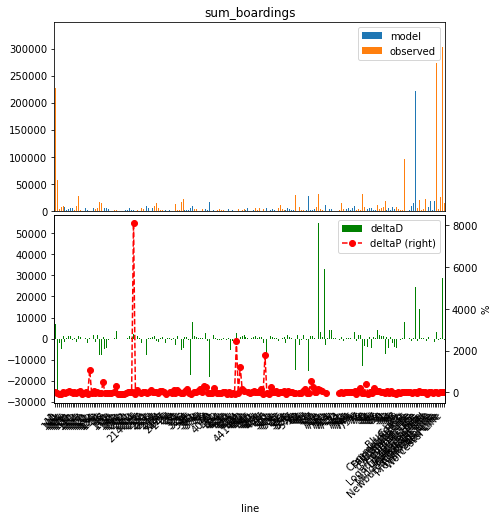

In [62]:
# ALL LINES
nb.compare_oneway(obsrvdf = daily_mod,
                  modeldf = gdaily_mod,
                  aggcol = 'boardings',col = 'line', aggmtd='sum')

In [63]:
inf = np.inf
line_boardings = pd.read_csv('.\outputs\oneway_line_boardings.csv').query('abs(deltaP) > 50 & abs(deltaP) < @inf')
line_boardings = line_boardings.rename(columns={'model':'gtfs', 'observed':'2016'})
line_boardings['abs_deltaP'] = abs(line_boardings['deltaP'])
problem_lines = line_boardings.line.to_list()
line_boardings.sort_values(by='abs_deltaP', ascending=False)


,line,gtfs,2016,deltaD,deltaP,abs_deltaP
41,211,2019.762,24.612,1995.150,8106.41,8106.41
95,435,2666.622,104.805,2561.817,2444.37,2444.37
110,465,1761.926,93.991,1667.935,1774.57,1774.57
97,439,820.208,61.855,758.353,1226.02,1226.02
18,120,395.325,33.521,361.804,1079.34,1079.34
...,...,...,...,...,...,...
120,52,2557.273,1676.188,881.085,52.56,52.56
81,39,16762.317,34854.241,-18091.924,-51.91,51.91
99,441,4771.472,3149.161,1622.311,51.52,51.52
126,57,14378.523,29257.727,-14879.204,-50.86,50.86


In [68]:
line_boardings.to_csv('./outputs/high_deltaP_lines.csv')

##### Check 1.5 - look into routes where GTFS ridership == 0 but there was ridership in 2016

In [ ]:
line_ridership = pd.read_csv('.\outputs\oneway_line_boardings.csv').rename(columns={'model':'gtfs', 'observed':'2016'})
line_ridership.query('gtfs ==0')

### Boardings by Time of Day - Look at Specific Routes

In [69]:
chocula = 0
for x in problem_lines:
    todb = trn.mod_df.query(
        'line == @ x'
        ).groupby(['line','tod']).sum().reset_index().sort_values(by='boardings').merge(
            gtrn.mod_df.query(
                'line == @ x'
                ).groupby(['line','tod']).sum().reset_index().sort_values(by='boardings'), 
            on=['line','tod'], suffixes=['_2016','_gtfs']
            )
    todb['deltad'] = todb['boardings_gtfs'] - todb['boardings_2016']
    todb['deltap'] = todb['deltad']/todb['boardings_2016']*100
    if chocula == 0:
        otter = todb
    else:
        otter = otter.append(todb)
    chocula += 1


In [70]:
otter.to_csv('./outputs/problem_lines_tod.csv')

### For ever Problematic Route - look at these:
1. Route Daily Ridership (really for identifying problematic routes)
2. Route TOD Ridership
3. Route Frequency (TOD)
4. Stop Ridership

    1. Same number of STOPS?
    2. Same stops being used?
    3. A lot of 0's?
    4. A lot of suspiciously high numbers?

2. Route TOD Ridership

In [131]:
r = "37"

no weighted columns identified list index out of range:


(          model  observed    deltaD  deltaP
 tod                                        
 am      860.576   181.214   679.362  374.89
 md     1251.706   383.648   868.058  226.26
 pm     1604.064   464.089  1139.975  245.64
 nt      225.225   110.777   114.448  103.31
 daily  3941.572  1139.728  2801.844  245.83,
 array([<AxesSubplot:title={'center':'sum_boardings'}>,
        <AxesSubplot:xlabel='tod'>], dtype=object),
 'oneway_tod_boardings.csv')

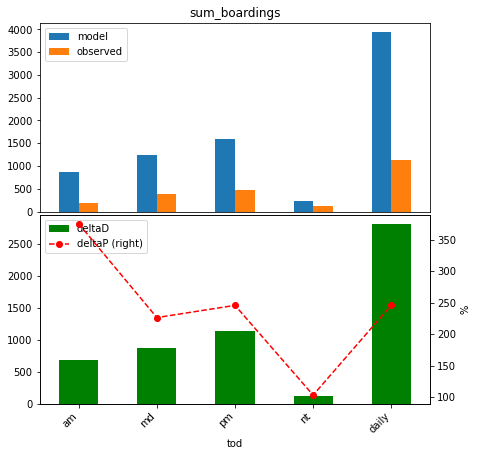

In [132]:
nb.compare_oneway(obsrvdf = trn.mod_df.query('line == @r'),
                  modeldf = gtrn.mod_df.query('line == @r'),
                  aggcol = 'boardings',col = 'tod', aggmtd='sum')

3. Route Frequency (TOD)

In [133]:
routes_freq.query('PRIMARY_RO == @r')

,PRIMARY_RO,am_freq_gtfs,md_freq_gtfs,pm_freq_gtfs,nt_freq_gtfs,am_freq_2016,md_freq_2016,pm_freq_2016,nt_freq_2016
72,37,18.0,19.666667,29.0,15.880952,NaN,NaN,NaN,NaN


4. Station Level Summaries - Look at Particular Routes Ridership at Stop Level

no weighted columns identified list index out of range:


(                                      model  observed  deltaD  deltaP
 stop                                                                 
 277 Belgrade Ave opp Rexhame St      22.020     0.000  22.020     inf
 3867 Washington St opp Tollgate Way   1.992     0.000   1.992     inf
 83 Lasell St opp Atlantis St          4.136     0.000   4.136     inf
 BAKER STREET @ LASELL STREET          0.000    12.309 -12.309  -100.0
 BAKER STREET @ VERMONT STREET         0.000     0.000   0.000     NaN
 ...                                     ...       ...     ...     ...
 Washington St @ Mosgrove Ave          1.614     0.000   1.614     inf
 Washington St @ South St              2.222     0.000   2.222     inf
 Washington St @ Tollgate Way          0.000     0.000   0.000     NaN
 Washington St @ Whipple Ave           0.003     0.000   0.003     inf
 Washington St opp Granfield Ave      18.890     0.000  18.890     inf
 
 [86 rows x 4 columns],
 array([<AxesSubplot:title={'center':'sum_boardings

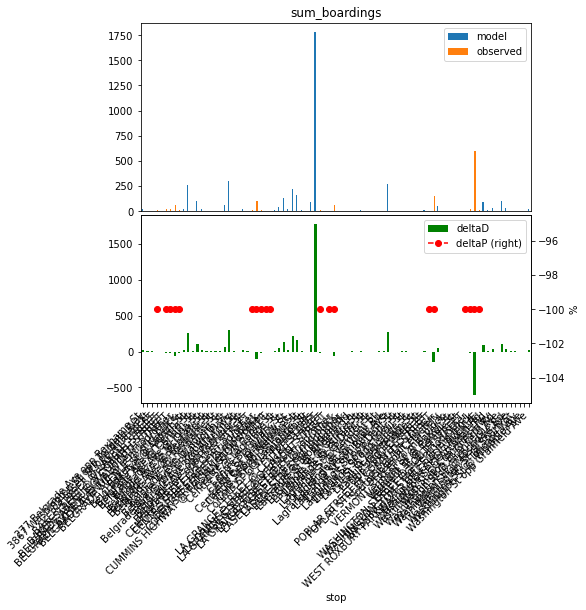

In [134]:
line = r
tod = 'daily'

nb.compare_oneway(obsrvdf = trn.mod_df.query("line == '{line}' & tod == '{tod}'".format(line=line,tod=tod)),
                  modeldf = gtrn.mod_df.query("line == '{line}' & tod == '{tod}'".format(line=line,tod=tod)),
                  aggcol = 'boardings',col = 'stop', aggmtd='sum')

If Daily is not enough, look at TOD

no weighted columns identified list index out of range:


(                                     model  observed  deltaD  deltaP
 stop                                                                
 277 Belgrade Ave opp Rexhame St      3.657     0.000   3.657     inf
 3867 Washington St opp Tollgate Way  0.146     0.000   0.146     inf
 83 Lasell St opp Atlantis St         1.245     0.000   1.245     inf
 BAKER STREET @ LASELL STREET         0.000     1.292  -1.292  -100.0
 BAKER STREET @ VERMONT STREET        0.000     0.000   0.000     NaN
 ...                                    ...       ...     ...     ...
 Washington St @ Mosgrove Ave         0.000     0.000   0.000     NaN
 Washington St @ South St             0.065     0.000   0.065     inf
 Washington St @ Tollgate Way         0.000     0.000   0.000     NaN
 Washington St @ Whipple Ave          0.000     0.000   0.000     NaN
 Washington St opp Granfield Ave      5.136     0.000   5.136     inf
 
 [86 rows x 4 columns],
 array([<AxesSubplot:title={'center':'sum_boardings'}>,
        

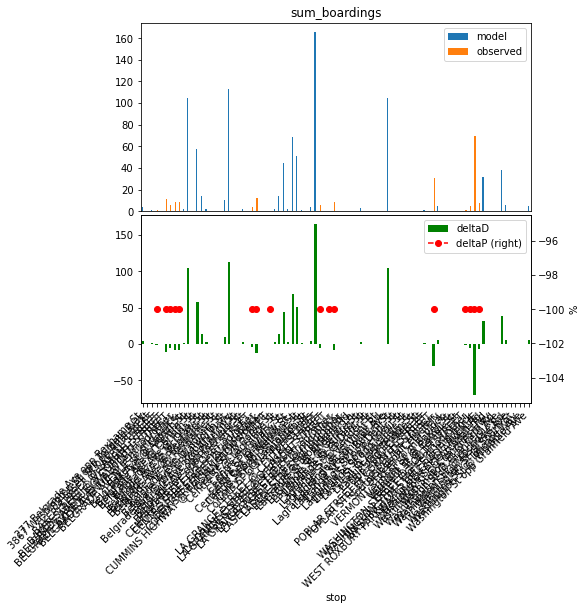

In [135]:
line = r
tod = 'am'

nb.compare_oneway(obsrvdf = trn.mod_df.query("line == '{line}' & tod == '{tod}'".format(line=line,tod=tod)),
                  modeldf = gtrn.mod_df.query("line == '{line}' & tod == '{tod}'".format(line=line,tod=tod)),
                  aggcol = 'boardings',col = 'stop', aggmtd='sum')

### STOPS TOP 50

In [85]:
trn.mod_df

,mode,operator,line,stop,tod,boardings
0,lbus,,,,daily,0.000000
1,lbus,,,,am,0.000000
2,lbus,,,,md,0.000000
3,lbus,,,,pm,0.000000
4,lbus,,,,nt,0.000000
...,...,...,...,...,...,...
38985,regb,Massport,Logan_Express_Bus,RING ROAD,daily,352.083063
38986,regb,Massport,Logan_Express_Bus,RING ROAD,am,59.672003
38987,regb,Massport,Logan_Express_Bus,RING ROAD,md,132.688640
38988,regb,Massport,Logan_Express_Bus,RING ROAD,pm,88.408600


In [89]:
gstops = gtrn.mod_df.query('tod == "daily"').groupby(['stop']).agg({'boardings':'sum'})
stops = trn.mod_df.query('tod == "daily"').groupby(['stop']).agg({'boardings':'sum'})
top_stops_gtfs = gstops.nlargest(50, 'boardings')
top_stops_2016 =stops.nlargest(50, 'boardings')

# just local bus
gstops = gtrn.mod_df.query('tod == "daily" & mode == "lbus"').groupby(['stop']).agg({'boardings':'sum'})
stops = trn.mod_df.query('tod == "daily" & mode == "lbus"').groupby(['stop']).agg({'boardings':'sum'})
top_stops_gtfs_lbus = gstops.nlargest(50, 'boardings')
top_stops_2016_lbus =stops.nlargest(50, 'boardings')

In [90]:
top_stops_gtfs.reset_index().merge(top_stops_2016.reset_index(), how='outer', on='stop', suffixes=['_gtfs','_2016'])

,stop,boardings_gtfs,boardings_2016
0,DOWNTOWN CROSSING,74172.910037,68149.679670
1,PARK STREET,72109.356943,58526.444222
2,STATE STREET,53900.598972,51614.165987
3,Moody St @ Main St,51159.947222,NaN
4,SOUTH STATION,33913.042372,32955.289754
...,...,...,...
57,WELLINGTON,NaN,11723.136719
58,MAIN STREET @ ESSEX STREET,NaN,9949.203915
59,MAIN STREET @ centriod/other,NaN,9820.715720
60,MASSACHUSETTS AVENUE @ NEWBURY STREET,NaN,9129.555699


In [91]:
top_stops_gtfs_lbus.reset_index().merge(top_stops_2016_lbus.reset_index(), how='outer', on='stop', suffixes=['_gtfs','_2016'])

,stop,boardings_gtfs,boardings_2016
0,Moody St @ Main St,51159.947222,NaN
1,Forest Hills,31549.088344,NaN
2,Western Ave @ Green St,24630.840648,NaN
3,Franklin St @ Sidney St,23492.508360,NaN
4,Harvard,13706.200071,NaN
...,...,...,...
89,COLUMBUS AVENUE @ CENTRE STREET,NaN,3336.859372
90,CENTRE STREET @ mid-block,NaN,3217.467828
91,SAINT JAMES AVENUE @ DARTMOUTH STREET,NaN,2854.406676
92,HAMPSHIRE STREET @ INMAN STREET,NaN,2804.806422


Look at Stop locations where only in one top 50 column - see if overlaps with another stop in the other top 50 column

## EXTRAS

In [ ]:
trn.mod_df.to_csv('./outputs/o2016_mod_df.csv')
gtrn.mod_df.to_csv('./outputs/gtfs_mod_df.csv')

##### Find out what is going on with Routes with 0 ridership in gtfs

In [ ]:
noride = ["5","114","191","192","193","194"]
routes_freq.reset_index().query('PRIMARY_RO in @noride')

In [ ]:
nb.compare_oneway(obsrvdf = tod_mod.query("line == '5'"),
                  modeldf = gtod_mod.query("line == '5'"),
                  aggcol = 'boardings',col = 'tod', aggmtd='sum')